# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [69]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

Device: mps


In [70]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [71]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, map_location=device)
model.to(device)
model.eval()

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/158852259.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=de

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

3_label7.png: Pred: 3, Label: 7
1_label3.png: Pred: 1, Label: 3
4_label2.png: Pred: 6, Label: 2
2_label3.png: Pred: 1, Label: 3
0_label5.png: Pred: 1, Label: 5


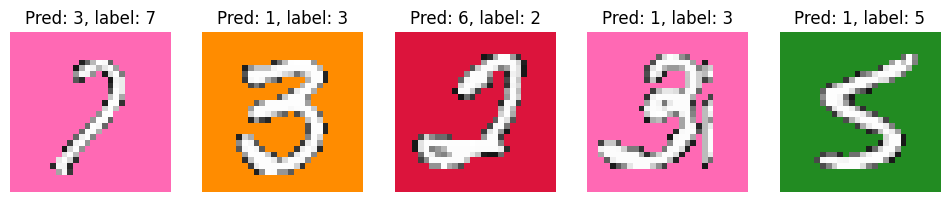

In [72]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

### Dataset & DataLoader (lee sample/ y challenge/, etiqueta del nombre)

In [73]:
from pathlib import Path
from PIL import Image
import re, torch
from torchvision import transforms

# usa tus to_tensor / to_pil ya definidos
def parse_label(fname: str):
    m = re.search(r'_label(\d+)\.png$', fname)
    return int(m.group(1)) if m else int(Path(fname).stem[-1])

class FolderDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.files = sorted(Path(root_dir).glob('*.png'))
        assert len(self.files) > 0, f"Sin PNGs en {root_dir}"
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert('RGB').resize((28,28))
        x = to_tensor(img)                 # [3,28,28]
        y = parse_label(p.name)
        return x, y, str(p)

def make_loader(path, bs=64):
    return torch.utils.data.DataLoader(FolderDataset(path), batch_size=bs, shuffle=False)

dl_sample    = make_loader('../data/MNIST/sample')
dl_challenge = make_loader('../data/MNIST/challenge/edited')
len(dl_sample.dataset), len(dl_challenge.dataset)


(10000, 5)

### Inferencia en lote + DataFrame/CSV

In [74]:
import pandas as pd
import torch.nn.functional as F

@torch.no_grad()
def predict_all(model, loader, device):
    rows = []
    for xb, yb, pb in loader:
        xb = xb.to(device)
        logits = model(xb)
        prob = F.softmax(logits, dim=1)
        conf, pred = prob.max(1)
        for i in range(xb.size(0)):
            rows.append({
                'path': pb[i],
                'label': int(yb[i]),
                'pred': int(pred[i]),
                'conf': float(conf[i]),
                **{f'p{k}': float(prob[i,k]) for k in range(10)}
            })
    return pd.DataFrame(rows)

df_sample    = predict_all(model, dl_sample, device)
df_challenge = predict_all(model, dl_challenge, device)

df_sample.to_csv('../data/MNIST/sample_preds.csv', index=False)
df_challenge.to_csv('../data/MNIST/challenge_preds.csv', index=False)

print('sample acc:', (df_sample.pred==df_sample.label).mean())
print('challenge acc:', (df_challenge.pred==df_challenge.label).mean())



sample acc: 0.7196
challenge acc: 0.0


In [75]:

df_sample.head()

,path,label,pred,conf,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,../data/MNIST/sample/00000_idx0_label7.png,7,9,0.478865,0.000255,5.567973e-04,0.000373,5.356643e-03,0.021750,9.217982e-03,0.046576,4.323789e-01,0.004669,4.788652e-01
1,../data/MNIST/sample/00001_idx1_label2.png,2,2,0.841987,0.004476,8.480680e-12,0.841987,8.557539e-11,0.001008,1.136868e-08,0.146423,7.702062e-13,0.006107,7.426890e-13
2,../data/MNIST/sample/00002_idx2_label1.png,1,1,0.297007,0.016178,2.970071e-01,0.009208,2.589439e-01,0.007789,2.226218e-01,0.015281,9.445409e-02,0.020584,5.793344e-02
3,../data/MNIST/sample/00003_idx3_label0.png,0,0,0.941117,0.941117,9.154581e-11,0.006714,4.081886e-11,0.001095,2.078366e-08,0.049775,7.595002e-11,0.001299,1.689984e-11
4,../data/MNIST/sample/00004_idx4_label4.png,4,4,0.985357,0.000033,4.537991e-17,0.000202,2.044186e-16,0.985357,4.044026e-13,0.002034,7.268429e-14,0.012375,7.813033e-16


In [76]:
df_challenge.head()

,path,label,pred,conf,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,../data/MNIST/challenge/edited/0_label5.png,5,1,0.297007,0.016178,2.970071e-01,0.009208,2.589439e-01,0.007789,2.226218e-01,0.015281,9.445409e-02,0.020584,5.793344e-02
1,../data/MNIST/challenge/edited/1_label3.png,3,1,0.297007,0.016178,2.970071e-01,0.009208,2.589439e-01,0.007789,2.226218e-01,0.015281,9.445409e-02,0.020584,5.793344e-02
2,../data/MNIST/challenge/edited/2_label3.png,3,1,0.297007,0.016178,2.970071e-01,0.009208,2.589439e-01,0.007789,2.226218e-01,0.015281,9.445409e-02,0.020584,5.793344e-02
3,../data/MNIST/challenge/edited/3_label7.png,7,3,0.231726,0.014017,1.993954e-01,0.008931,2.317263e-01,0.012538,2.164780e-01,0.024859,1.613207e-01,0.024536,1.061987e-01
4,../data/MNIST/challenge/edited/4_label2.png,2,6,0.455016,0.108265,4.519096e-12,0.434832,8.589031e-12,0.000618,6.445534e-09,0.455016,3.178385e-13,0.001268,5.347470e-13


### Técnicas de XAI

### GRADCAM

In [77]:
# cierra gradcam viejo si existe
try:
    gradcam.close()
except Exception:
    pass

# elimina TODOS los hooks de todos los submódulos (forward/backward)
def _clear_all_hooks(module):
    for m in module.modules():
        for attr in ("_forward_hooks", "_forward_pre_hooks", "_backward_hooks"):
            d = getattr(m, attr, None)
            if isinstance(d, dict):
                d.clear()

_clear_all_hooks(model)
print("hooks limpiados correctamente ✅")


hooks limpiados correctamente ✅


In [78]:
import torch
import torch.nn.functional as F

class GradCAM_SAFE:
    def __init__(self, model, layer_module):
        self.model = model.eval()
        self.activations = None
        self.gradients = None

        def fwd_hook(_, __, out):
            self.activations = out
            if out.requires_grad:
                def bwd_hook(grad):
                    self.gradients = grad
                out.register_hook(bwd_hook)
            else:
                self.gradients = None  # forward sin gradientes

        self.h = layer_module.register_forward_hook(fwd_hook)

    def __call__(self, x, target):
        x = x.unsqueeze(0) if x.dim()==3 else x
        x = x.to(device).detach().requires_grad_(True)
        logits = self.model(x)
        score = logits[0, target]
        self.model.zero_grad(set_to_none=True)
        score.backward()

        A, dA = self.activations, self.gradients
        assert (A is not None) and (dA is not None), "No hay gradientes/activaciones (¿forward bajo no_grad?)."

        w = dA.mean(dim=(2,3), keepdim=True)
        cam = torch.relu((w * A).sum(1, keepdim=True))
        cam = F.interpolate(cam, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)[0,0]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.detach().cpu()

    def close(self):
        self.h.remove()

# crear nueva instancia del GradCAM con tu modelo
gradcam = GradCAM_SAFE(model, model.conv1)
print("GradCAM reinstanciado correctamente ✅")


GradCAM reinstanciado correctamente ✅


In [79]:
import numpy as np, cv2, torch
from torchvision.utils import save_image
from pathlib import Path
from matplotlib import cm

def colorize_cam(cam_01):
    # cam_01 -> np.float32 [H,W] en 0..1, luego aplica 'jet' y quita alfa
    if isinstance(cam_01, torch.Tensor):
        cam = cam_01.detach().cpu().squeeze().float().numpy()
    else:
        cam = np.array(cam_01, dtype=np.float32)
    cam = np.nan_to_num(cam, nan=0.0, posinf=1.0, neginf=0.0)
    cam = np.clip(cam, 0.0, 1.0).astype(np.float32)
    jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1
    return jet.astype(np.float32)

def overlay_color(x01, cam01, alpha=0.55):
    base = x01.detach().cpu().permute(1,2,0).float().numpy()      # (H,W,3) 0..1
    base = np.clip(base, 0.0, 1.0).astype(np.float32)
    heat = colorize_cam(cam01)                                     # (H,W,3) 0..1
    out  = np.clip((1 - alpha) * base + alpha * heat, 0.0, 1.0)
    return torch.from_numpy(out).permute(2,0,1) 

def save_xai_split(split_loader, split_name, target="true"):
    """
    target: "true" (etiqueta) o "pred" (clase predicha)
    """
    out_dir = Path(f'../data/MNIST/gradcam/{split_name}_xai')
    out_dir.mkdir(parents=True, exist_ok=True)

    for xb, yb, pb in split_loader:
        with torch.no_grad():
            preds = model(xb.to(device)).argmax(1).cpu()

        for i in range(xb.size(0)):
            x = xb[i]
            y = int(yb[i])
            pred = int(preds[i])
            tgt = y if target=="true" else pred

            cam = gradcam(x, tgt)          # torch[H,W] en 0..1
            ov  = overlay_color(x.cpu(), cam, alpha=0.55)

            stem = Path(pb[i]).stem
            suffix = "true" if target=="true" else "pred"
            save_image(ov, out_dir/f'{stem}_cam_{suffix}.png')

    print('guardado en', out_dir)

# ejemplos:
save_xai_split(dl_sample, 'sample', target="true")

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/2929275833.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


guardado en ../data/MNIST/gradcam/sample_xai


In [80]:
import numpy as np, cv2, torch
from torchvision.utils import save_image
from pathlib import Path
from matplotlib import cm

def colorize_cam(cam_01):
    # cam_01 -> np.float32 [H,W] en 0..1, luego aplica 'jet' y quita alfa
    if isinstance(cam_01, torch.Tensor):
        cam = cam_01.detach().cpu().squeeze().float().numpy()
    else:
        cam = np.array(cam_01, dtype=np.float32)
    cam = np.nan_to_num(cam, nan=0.0, posinf=1.0, neginf=0.0)
    cam = np.clip(cam, 0.0, 1.0).astype(np.float32)
    jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1
    return jet.astype(np.float32)

def overlay_color(x01, cam01, alpha=0.55):
    base = x01.detach().cpu().permute(1,2,0).float().numpy()      # (H,W,3) 0..1
    base = np.clip(base, 0.0, 1.0).astype(np.float32)
    heat = colorize_cam(cam01)                                     # (H,W,3) 0..1
    out  = np.clip((1 - alpha) * base + alpha * heat, 0.0, 1.0)
    return torch.from_numpy(out).permute(2,0,1) 

def save_xai_split(split_loader, split_name, target="true"):
    """
    target: "true" (etiqueta) o "pred" (clase predicha)
    """
    out_dir = Path(f'../data/MNIST/gradcam/{split_name}_xai')
    out_dir.mkdir(parents=True, exist_ok=True)

    for xb, yb, pb in split_loader:
        with torch.no_grad():
            preds = model(xb.to(device)).argmax(1).cpu()

        for i in range(xb.size(0)):
            x = xb[i]
            y = int(yb[i])
            pred = int(preds[i])
            tgt = y if target=="true" else pred

            cam = gradcam(x, tgt)          # torch[H,W] en 0..1
            ov  = overlay_color(x.cpu(), cam, alpha=0.55)

            stem = Path(pb[i]).stem
            suffix = "true" if target=="true" else "pred"
            save_image(ov, out_dir/f'{stem}_cam_{suffix}.png')

    print('guardado en', out_dir)

# ejemplos:
save_xai_split(dl_challenge, 'challenge', target="true")

guardado en ../data/MNIST/gradcam/challenge_xai


/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/3085249586.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


### INTEGRATED GRADIENTS

In [81]:
import torch
import torch.nn.functional as F

def make_baseline(x, kind="black"):
    if kind == "black":  return torch.zeros_like(x)
    if kind == "white":  return torch.ones_like(x)
    if kind == "blur":
        k, pad = 5, 2
        xx = x.unsqueeze(0)
        ker = torch.ones(1,1,k,k, device=xx.device) / (k*k)
        ch = [F.conv2d(xx[:,c:c+1], ker, padding=pad) for c in range(xx.size(1))]
        return torch.cat(ch, dim=1).squeeze(0).clamp(0,1)
    raise ValueError(kind)

def integrated_gradients(model, x, target, steps=50, baseline_kind="black", signed=False, device=None):
    device = device or next(model.parameters()).device
    x = x.to(device)
    baseline = make_baseline(x, baseline_kind).to(device)

    grads_sum = torch.zeros_like(x)
    torch.set_grad_enabled(True)

    for i in range(1, steps+1):
        alpha = i/steps
        xi = (baseline + alpha*(x - baseline)).unsqueeze(0)   # [1,3,H,W]
        xi.requires_grad_(True)
        logits = model(xi)
        score  = logits[0, target]
        # grad w.r.t. input directly (robusto; no depende de xi.grad)
        grad = torch.autograd.grad(score, xi, retain_graph=False, create_graph=False, allow_unused=True)[0]
        if grad is None:
            raise RuntimeError("autograd.grad devolvió None; revisa que no estés en torch.inference_mode()")
        grads_sum += grad.squeeze(0)

    avg_grad = grads_sum / steps
    ig = (x - baseline) * avg_grad   # [3,H,W]
    if not signed:
        ig = ig.abs()
    ig = ig.max(dim=0, keepdim=False).values      # [H,W]
    ig = ig - ig.min()
    ig = ig / (ig.max() + 1e-8)
    return ig.detach().cpu()


In [82]:
from torchvision.utils import save_image
from pathlib import Path

def save_ig_split(split_loader, split_name, target="true", steps=50, baseline_kind="black", signed=False):
    """
    target: "true" (etiqueta) o "pred" (clase predicha)
    """
    out_dir = Path(f'../data/MNIST/integrated_gradients/{split_name}_xai')
    out_dir.mkdir(parents=True, exist_ok=True)

    for xb, yb, pb in split_loader:
        # predicciones en batch para target="pred"
        with torch.no_grad():
            preds = model(xb.to(device)).argmax(1).cpu()

        for i in range(xb.size(0)):
            x = xb[i]
            y = int(yb[i])
            pred = int(preds[i])
            tgt = y if target == "true" else pred

            ig_map = integrated_gradients(model, x, tgt, steps=steps, baseline_kind=baseline_kind, signed=signed, device=device)
            ov    = overlay_color(x.cpu(), ig_map, alpha=0.55)  # usa tu overlay en color existente

            stem = Path(pb[i]).stem
            suffix = f"ig_{target}_s{steps}_{baseline_kind}{'_signed' if signed else ''}.png"
            save_image(ov, out_dir / f"{stem}_{suffix}")

    print("IG guardado en", out_dir)


In [83]:
# Ejemplos de ejecución:
save_ig_split(dl_challenge, 'edited_ig', target="true", steps=32, baseline_kind="black", signed=False)
# save_ig_split(dl_sample, 'sample', target="pred", steps=32, baseline_kind="blur", signed=False)
# save_ig_split(dl_sample, 'sample', target="true", steps=64, baseline_kind="white", signed=True)


IG guardado en ../data/MNIST/integrated_gradients/edited_ig_xai


/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/3085249586.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


In [84]:
save_ig_split(dl_challenge, 'challenge', target="true", steps=32, baseline_kind="black", signed=False)

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/3085249586.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


IG guardado en ../data/MNIST/integrated_gradients/challenge_xai


# SMOOTHGRAD
#### Calcula el mapa de importancia (gradiente suavizado) para una clase concreta.

In [192]:
def smoothgrad(model, x, y, n, noise):
    grads = torch.zeros_like(x)
    for _ in range(n):
        noise_tensor = torch.randn_like(x) * noise
        x_noisy = (x + noise_tensor).clamp(0,1)
        x_noisy.requires_grad_(True)
        out = model(x_noisy)
        score = out[0,y]
        model.zero_grad(set_to_none=True)
        score.backward()
        grads += x_noisy.grad.detach()
    grads = grads.abs().mean(1, keepdim=True)
    grads = grads[0] / grads.max()
    return grads.squeeze().cpu().numpy()


#### Crea dos carpetas con los mapas de calor de cada imagen defectuosa (challenge):
#### smooth_grad_predicted_label → mapa para la clase predicha
#### smooth_grad_true_label → mapa para la clase verdadera

In [193]:
from pathlib import Path
from PIL import Image
import numpy as np

def smooth_grad_predicted_label(img_path):
    img = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img).unsqueeze(0).to(device)   # [1,3,28,28]
    y_true = int(Path(img_path).stem[-1])

    with torch.no_grad():
        y_pred = int(model(x).argmax(1).item())

    #tgt = y_true if use_target=="true" else y_pred
    tgt = y_pred

    sg_map = smoothgrad(model, x.clone(), tgt, n=125, noise=0.3)

    ov_sg  = overlay_color(x.squeeze(0).cpu(), torch.as_tensor(sg_map),      alpha=0.55)

    out_dir = Path("../data/MNIST/smooth_grad_predicted_label"); out_dir.mkdir(parents=True, exist_ok=True)
    stem = Path(img_path).stem
    from torchvision.utils import save_image
    save_image(ov_sg,  out_dir/f"{stem}_SG_predicted_label.png")
    return y_true, y_pred


In [194]:
challenge_dir = Path("../data/MNIST/challenge")
img_paths = sorted(challenge_dir.glob("*.png"))
for p in img_paths:
    yt, yp = smooth_grad_predicted_label(
        p)
    print(p.name, "pred=", yp, "true=", yt)
print("Listo ✅  (archivos en ../data/MNIST/smooth_grad_predicted_label")

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/3085249586.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


0_label5.png pred= 1 true= 5
1_label3.png pred= 1 true= 3
2_label3.png pred= 1 true= 3
3_label7.png pred= 3 true= 7
4_label2.png pred= 6 true= 2
Listo ✅  (archivos en ../data/MNIST/smooth_grad_predicted_label


In [195]:
def smooth_grad_true_label(img_path):
    img = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img).unsqueeze(0).to(device)   # [1,3,28,28]
    y_true = int(Path(img_path).stem[-1])

    with torch.no_grad():
        y_pred = int(model(x).argmax(1).item())

    #tgt = y_true if use_target=="true" else y_pred
    tgt = y_true

    sg_map = smoothgrad(model, x.clone(), tgt, n=125, noise=0.3)

    ov_sg  = overlay_color(x.squeeze(0).cpu(), torch.as_tensor(sg_map), alpha=0.55)

    out_dir = Path("../data/MNIST/smooth_grad_true_label"); out_dir.mkdir(parents=True, exist_ok=True)
    stem = Path(img_path).stem
    from torchvision.utils import save_image
    save_image(ov_sg,  out_dir/f"{stem}_SG_true_label.png")
    return y_true, y_pred

In [196]:
challenge_dir = Path("../data/MNIST/challenge")
img_paths = sorted(challenge_dir.glob("*.png"))
for p in img_paths:
    yt, yp = smooth_grad_true_label(
        p)
    print(p.name, "pred=", yp, "true=", yt)
print("Listo ✅  (archivos en ../data/MNIST/smooth_grad_true_label")

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_27206/3085249586.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')(cam)[:, :, :3]        # (H,W,3) RGB 0..1


0_label5.png pred= 1 true= 5
1_label3.png pred= 1 true= 3
2_label3.png pred= 1 true= 3
3_label7.png pred= 3 true= 7
4_label2.png pred= 6 true= 2
Listo ✅  (archivos en ../data/MNIST/smooth_grad_true_label


In [197]:
from torchvision.utils import save_image
from PIL import Image
import numpy as np

def _topk_mask_np(heat_01: np.ndarray, pct: float):
    H, W = heat_01.shape
    k = max(1, int(round(pct * H * W)))
    flat = heat_01.reshape(-1)
    idx = np.argpartition(-flat, k-1)[:k]
    mask = np.zeros_like(flat, dtype=bool)
    mask[idx] = True
    return mask.reshape(H, W)

def _edit_with_masks(x3: torch.Tensor, mask_remove: np.ndarray, mask_add: np.ndarray):
    mr = torch.from_numpy(mask_remove).to(x3.device)
    ma = torch.from_numpy(mask_add).to(x3.device)
    x_ed = x3.clone()
    x_ed[:, mr] = 0.0
    x_ed[:, ma] = 1.0
    changed = (mr | ma).float().mean().item()
    return x_ed, changed

@torch.no_grad()
def _pred_label(x3: torch.Tensor) -> int:
    return int(model(x3.unsqueeze(0).to(device)).argmax(1).item())

# --- crear máscara promedio por clase usando las imágenes correctas del sample ---
sample_dir = Path("../data/MNIST/sample")
mask_dir = Path("../data/MNIST/sample_sg_masks"); mask_dir.mkdir(parents=True, exist_ok=True)

def generate_avg_masks_from_sample_subset(
    target_labels=(2,3,5,7),
    max_per_class=20,      # tope de imágenes correctas por clase
    pct=0.15,              # top-% para la máscara binaria
    n_sg=64,               # menos iteraciones para ir rápido (antes 125)
    noise_sg=0.30,
    shuffle=True,          # opcional: barajar para muestreo aleatorio
    seed=42
):
    target_labels = set(map(int, target_labels))
    class_masks = {c: [] for c in target_labels}
    counts = {c: 0 for c in target_labels}

    files = sorted(sample_dir.glob("*.png"))
    if shuffle:
        rng = np.random.default_rng(seed)
        files = list(files)
        rng.shuffle(files)

    for p in files:
        label = int(p.stem[-1])
        if label not in target_labels:
            continue
        if counts[label] >= max_per_class:
            continue

        img = Image.open(p).convert("RGB").resize((28,28))
        x = to_tensor(img).unsqueeze(0).to(device)

        # solo ejemplos BIEN clasificados
        with torch.no_grad():
            y_pred = int(model(x).argmax(1).item())
        if y_pred != label:
            continue

        # SmoothGrad (rápido)
        sg_map = smoothgrad(model, x.clone(), label, n_sg, noise_sg)  # np[H,W] en 0..1
        mask = _topk_mask_np(sg_map, pct).astype(np.float32)          # 0/1
        class_masks[label].append(mask)
        counts[label] += 1

        # corta si ya has llenado todas
        if all(counts[c] >= max_per_class for c in target_labels):
            break

    # promedio por clase
    avg_masks = {}
    out_dir = Path("../data/MNIST/avg_masks_per_class"); out_dir.mkdir(parents=True, exist_ok=True)
    for c in target_labels:
        if class_masks[c]:
            avg = np.mean(np.stack(class_masks[c], axis=0), axis=0)   # en [0,1]
            avg_masks[c] = avg / (avg.max() + 1e-8)
            np.save(out_dir / f"avg_mask_{c}.npy", avg_masks[c])
            Image.fromarray((avg_masks[c]*255).astype(np.uint8)).save(out_dir / f"avg_mask_{c}.png")
            print(f"Clase {c}: {len(class_masks[c])} máscaras -> promedio guardado.")
        else:
            print(f"Clase {c}: 0 ejemplos válidos (no se genera promedio).")
    return avg_masks

# Ejecuta (solo 2,3,5,7; 20 por clase; n=64)
avg_masks = generate_avg_masks_from_sample_subset(
    target_labels=(2,3,5,7),
    max_per_class=20,
    pct=0.15,
    n_sg=64,
    noise_sg=0.30,
    shuffle=True,
    seed=42
)

avg_mask_dir = Path("../data/MNIST/avg_masks_per_class"); avg_mask_dir.mkdir(parents=True, exist_ok=True)

def build_avg_mask_for_5_fallback(
    max_per_class=20,     # cuántas imágenes usar como máximo
    pct=0.15,             # porcentaje top para la máscara binaria
    n_sg=64,              # menos iteraciones para ir rápido
    noise_sg=0.30
):
    files = sorted(sample_dir.glob("*.png"))

    # 1) candidatos donde el modelo PREDICE 5
    pred5 = []
    probs5 = []
    for p in files:
        img = Image.open(p).convert("RGB").resize((28,28))
        x = to_tensor(img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(x)
            y_pred = int(logits.argmax(1).item())
            prob5  = torch.softmax(logits, dim=1)[0,5].item()
        if y_pred == 5:
            pred5.append(p)
            probs5.append(prob5)

    # si no hay suficientes, 2) coge top-prob clase 5
    if len(pred5) < max_per_class:
        # ordena todas por prob5 desc y añade hasta completar
        all_scores = []
        for p in files:
            img = Image.open(p).convert("RGB").resize((28,28))
            x = to_tensor(img).unsqueeze(0).to(device)
            with torch.no_grad():
                prob5 = torch.softmax(model(x), dim=1)[0,5].item()
            all_scores.append((prob5, p))
        all_scores.sort(reverse=True, key=lambda t: t[0])
        for _, p in all_scores:
            if p in pred5: 
                continue
            pred5.append(p)
            if len(pred5) >= max_per_class:
                break

    if len(pred5) == 0:
        print("No se encontraron candidatos para clase 5.")
        return None

    # 3) SG wrt clase 5 -> máscara top-pct
    masks = []
    for p in pred5[:max_per_class]:
        img = Image.open(p).convert("RGB").resize((28,28))
        x = to_tensor(img).unsqueeze(0).to(device)
        sg_map = smoothgrad(model, x.clone(), 5, n_sg, noise_sg)  # np[H,W] en 0..1
        mask = _topk_mask_np(sg_map, pct).astype(np.float32)
        masks.append(mask)

    # 4) promedio y guardado
    avg = np.mean(np.stack(masks, axis=0), axis=0)
    avg = avg / (avg.max() + 1e-8)
    np.save(avg_mask_dir / "avg_mask_5.npy", avg)
    Image.fromarray((avg*255).astype(np.uint8)).save(avg_mask_dir / "avg_mask_5.png")
    print(f"Clase 5: {len(masks)} máscaras -> promedio guardado en {avg_mask_dir}")
    return avg

# Ejecuta el parche
avg5 = build_avg_mask_for_5_fallback(max_per_class=20, pct=0.15, n_sg=64, noise_sg=0.30)

# opcional: inserta/actualiza en tu dict avg_masks si lo estás usando aguas abajo
try:
    avg_masks
except NameError:
    avg_masks = {}
if avg5 is not None:
    avg_masks[5] = avg5


Clase 2: 20 máscaras -> promedio guardado.
Clase 3: 20 máscaras -> promedio guardado.
Clase 5: 0 ejemplos válidos (no se genera promedio).
Clase 7: 20 máscaras -> promedio guardado.
Clase 5: 20 máscaras -> promedio guardado en ../data/MNIST/avg_masks_per_class


In [ ]:
import pandas as pd

def edit_image_sg_with_avg(img_path,
                           remove_pct=0.15,
                           add_pct=0.15,
                           max_budget=0.40):
    img = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img).to(device)
    y_true = int(Path(img_path).stem[-1])
    y_pred = _pred_label(x)

    sg_pred = smoothgrad(model, x.unsqueeze(0).clone(), y_pred, n=125, noise=0.3)
    sg_true = smoothgrad(model, x.unsqueeze(0).clone(), y_true, n=125, noise=0.3)

    # máscara de la predicha (negro)
    m_remove = _topk_mask_np(sg_pred, remove_pct)

    # máscara de la verdadera (blanco)
    m_add = _topk_mask_np(sg_true, add_pct).astype(np.float32)

    # si hay máscara promedio de esa clase, la añadimos
    if y_true in avg_masks:
        m_add = np.clip(m_add + avg_masks[y_true], 0, 1)

    # controlar presupuesto máximo
    union_frac = (m_remove | (m_add>0.5)).mean()
    if union_frac > max_budget:
        scale = max_budget / (union_frac + 1e-8)
        m_remove = _topk_mask_np(sg_pred, remove_pct*scale)
        m_add = _topk_mask_np(sg_true, add_pct*scale)

    x_edit, changed_frac = _edit_with_masks(x, m_remove, m_add>0.5)
    new_pred = _pred_label(x_edit)

    out_dir = Path("../data/MNIST/challenge/edited"); out_dir.mkdir(parents=True, exist_ok=True)
    save_image(x_edit.cpu(), out_dir/f"{Path(img_path).stem}_edited.png")

    return {
        "file": Path(img_path).stem,
        "true": y_true,
        "pred_before": y_pred,
        "pred_after": new_pred,
        "changed_frac": changed_frac
    }

rows = []
for p in sorted(challenge_dir.glob("*.png")):
    r = edit_image_sg_with_avg(p)
    rows.append(r)
    print(f"{p.name}: {r['pred_before']}→{r['pred_after']} | edit={r['changed_frac']*100:.1f}%")

df = pd.DataFrame(rows)
df.to_csv("../data/MNIST/challenge/edited_summary.csv", index=False)
print("Imágenes editadas en ../data/MNIST/challenge/edited")


0_label5.png: 1→9 | edit=40.8%
1_label3.png: 1→7 | edit=43.6%
2_label3.png: 1→1 | edit=39.3%
3_label7.png: 3→9 | edit=41.3%
4_label2.png: 6→8 | edit=42.7%
Imágenes editadas en ../data/MNIST/challenge/edited


In [ ]:
# import pandas as pd

# challenge_dir = Path("../data/MNIST/challenge")
# rows = []
# for p in sorted(challenge_dir.glob("*.png")):
#     r = edit_image_sg(
#         p,
#         remove_pct=0.15,   # píxeles “predicha” que quitamos (negro)
#         add_pct=0.15,      # píxeles “verdadera” que añadimos (blanco)
#         max_budget=0.40,   # garantiza ≥60% sin cambiar
#         n=125, noise=0.3
#     )
#     rows.append(r)
#     print(f"{p.name}: {r['pred_before']}→{r['pred_after']}  changed={r['changed_frac']*100:.1f}%")

# df = pd.DataFrame(rows)
# df.to_csv("../data/MNIST/challenge/edited_summary.csv", index=False)
# print("\nImágenes editadas en: ../data/MNIST/challenge/edited")
# print("Resumen CSV en:      ../data/MNIST/challenge/edited_summary.csv")
# print("Accuracy antes:", (df.pred_before==df.true).mean(), "después:", (df.pred_after==df.true).mean())


0_label5.png: 1→9  changed=18.8%
1_label3.png: 1→5  changed=27.9%
2_label3.png: 1→1  changed=17.1%
3_label7.png: 3→7  changed=18.9%
4_label2.png: 6→8  changed=21.7%

Imágenes editadas en: ../data/MNIST/challenge/edited
Resumen CSV en:      ../data/MNIST/challenge/edited_summary.csv
Accuracy antes: 0.0 después: 0.2


In [ ]:
# from pathlib import Path

# # ruta base del dataset challenge
# challenge_dir = Path("../data/MNIST/challenge")

# # carpeta donde guardaste tus imágenes modificadas
# edited_dir = challenge_dir / "edited"

# print("Challenge dir:", challenge_dir)
# print("Edited dir:", edited_dir)


Challenge dir: ../data/MNIST/challenge
Edited dir: ../data/MNIST/challenge/edited


In [207]:
from pathlib import Path
import shutil

challenge_dir = Path("../data/MNIST/challenge")
edited_dir    = challenge_dir / "edited"

# Si tus archivos actuales tienen sufijo "_edited.png", renómbralos a su nombre original.
for orig in sorted(challenge_dir.glob("*.png")):
    stem = orig.stem  # p.ej. "0_label5"
    cand = edited_dir / f"{stem}_edited.png"
    if cand.exists():
        target = edited_dir / f"{stem}.png"
        if target.exists():
            target.unlink()
        shutil.move(str(cand), str(target))


---
## Check if you have passed the challenge 

In [208]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [210]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 3_label7.png: Pred: 9, Label: 7, correct: False
Edit Percentage: 41.07%
Edited 1_label3.png: Pred: 7, Label: 3, correct: False
Edit Percentage: 43.62%
Edited 4_label2.png: Pred: 8, Label: 2, correct: False
Edit Percentage: 42.73%
Edited 2_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 39.16%
Edited 0_label5.png: Pred: 9, Label: 5, correct: False
Edit Percentage: 40.69%
